# <font color = 'Navy Blue'>Amazon Orders Analysis 

<font color = 'Blue'>This project extracts my personal order data from Amazon.com
<br>It spans from year 2018 to 2020

<b> Here are the step by step actions the web scraper will perform to scrape Amazon spending data: </b>

> - Launches a Chrome browser controlled by Selenium <br>
> - Navigates to the Amazon login page <br>
> - Waits 30 seconds for you to manually log in <br>
> - After login, navigates to the Orders page <br>
> - Scrapes Item Costs, Order IDs, and Order Dates <br>
> - Repeats for each year in the year filter and each page in the pagination filter until finished <br>
> - Outputs the data model to a CSV file <br>

In [18]:
import numpy as np
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import requests
import csv
import datetime
import time

import os  
from selenium import webdriver  
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options 

In [19]:
class AmazonOrderScraper:
    
    def __init__(self):
        self.date = np.array([])
        self.cost = np.array([])
        self.order_id = np.array([])
        
    
    def URL(self, year: int, start_index: int) -> str:
        return "https://www.amazon.com/gp/css/order-history/ref=ppx_yo_dt_b_pagination_1_4?ie=UTF8&orderFilter=year-" + \
                str(year) + \
                "&search=&startIndex=" + \
                str(start_index)
    
    
    def scrape_order_data(self, start_year: int, end_year: int) -> pd.DataFrame:
        years = list(range(start_year, end_year + 1))
        driver = self.start_driver_and_manually_login_to_amazon()

        for year in years:
            driver.get(
                self.URL(year, 0)
            )
            
            number_of_pages = self.find_max_number_of_pages(driver)
            
            self.scrape_first_page_before_progressing(driver)

            for i in range(number_of_pages):
                self.scrape_page(driver, year, i)

            print(f"Order data extracted for { year }") 
            
        driver.close()
        
        print("Scraping done :)")
            
        order_data = pd.DataFrame({
            "Date": self.date,
            "Cost $": self.cost,
            "Order ID": self.order_id
        })
        
        order_data = self.prepare_dataset(order_data)
        
        order_data.to_csv(r"amazon-orders.csv")
            
        return order_data
    

    def start_driver_and_manually_login_to_amazon(self) -> webdriver:
        options = webdriver.ChromeOptions()
        options.add_argument("--start-maximized")
        
        driver = webdriver.Chrome("chromedriver.exe", options=options)
        driver.get("https://www.amazon.com/ap/signin?_encoding=UTF8&accountStatusPolicy=P1&openid.assoc_handle=gbflex&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.mode=checkid_setup&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&openid.ns.pape=http%3A%2F%2Fspecs.openid.net%2Fextensions%2Fpape%2F1.0&openid.pape.max_auth_age=0&openid.return_to=https%3A%2F%2Fwww.amazon.co.uk%2Fgp%2Fcss%2Forder-history%3Fie%3DUTF8%26ref_%3Dnav_orders_first&pageId=webcs-yourorder&showRmrMe=1")
        time.sleep(60) # allows time for manual sign in - increase if you need more time
        
        
        return driver
    
    
    def find_max_number_of_pages(self, driver: webdriver) -> int:
        time.sleep(2)
        page_source = driver.page_source
        page_content = BeautifulSoup(page_source, "html.parser")

        a_normal = page_content.findAll("li", {"class": "a-normal"})
        a_selected = page_content.findAll("li", {"class": "a-selected"})
        max_pages = len(a_normal + a_selected) - 1
       

        return max_pages
    
    
    def scrape_first_page_before_progressing(self, driver: webdriver) -> None:
        time.sleep(2)
        page_source = driver.page_source
        page_content = BeautifulSoup(page_source, "html.parser")
        order_info = page_content.findAll("span", {"class": "a-color-secondary value"})

        orders = []
        for i in order_info:
            orders.append(i.text.strip())

        index = 0
        for i in orders:
            if index == 0:
                self.date = np.append(self.date, i)
                index += 1
            elif index == 1:
                self.cost = np.append(self.cost, i)
                index += 1
            elif index == 2:
                self.order_id = np.append(self.order_id, i)
                index = 0
    
    
    def scrape_page(self, driver: webdriver, year: int, i: int) -> None:
        start_index = list(range(10, 110, 10))
        
        driver.get(
            self.URL(year, start_index[i])
        )
        time.sleep(2)

        data = driver.page_source
        page_content = BeautifulSoup(data, "html.parser")

        order_info = page_content.findAll("span", {"class": "a-color-secondary value"})

        orders = []
        for i in order_info:
            orders.append(i.text.strip())

        index = 0
        for i in orders:
            if index == 0:
                self.date = np.append(self.date, i)
                index += 1
            elif index == 1:
                self.cost = np.append(self.cost, i)
                index += 1
            elif index == 2:
                self.order_id = np.append(self.order_id, i)
                index = 0
                
    
    def prepare_dataset(self, order_data: pd.DataFrame) -> pd.DataFrame:
        order_data.set_index("Order ID", inplace=True)

        order_data["Cost $"] = order_data["Cost $"].str.replace("$", "").astype(float)
        order_data['Order Date'] = pd.to_datetime(order_data['Date'])
        order_data["Year"] = pd.DatetimeIndex(order_data['Order Date']).year
        order_data['Month Number'] = pd.DatetimeIndex(order_data['Order Date']).month
        order_data['Day'] = pd.DatetimeIndex(order_data['Order Date']).dayofweek
        
        dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
        order_data["Day Of Week"] = order_data['Order Date'].dt.dayofweek.map(dayOfWeek)
        
        month = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
        order_data["Month"] = order_data['Order Date'].dt.month.map(month)
        
        
        return order_data


if __name__ == "__main__":
    aos = AmazonOrderScraper()
    order_data = aos.scrape_order_data(start_year = 2018, end_year = 2021)
    print(order_data.head(3))

Order data extracted for 2018
Order data extracted for 2019
Order data extracted for 2020
Order data extracted for 2021
Scraping done :)
                                  Date  Cost $ Order Date  Year  Month Number  \
Order ID                                                                        
113-4608705-4633828  November 29, 2018   13.99 2018-11-29  2018            11   
113-8314371-0821809  November 29, 2018   18.99 2018-11-29  2018            11   
113-8541882-2459422   October 27, 2018    4.22 2018-10-27  2018            10   

                     Day Day Of Week     Month  
Order ID                                        
113-4608705-4633828    3    Thursday  November  
113-8314371-0821809    3    Thursday  November  
113-8541882-2459422    5    Saturday   October  


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})

In [21]:
order_data.describe()

,Cost $,Year,Month Number,Day
count,254.000000,254.000000,254.000000,254.000000
mean,31.810433,2020.023622,8.059055,3.102362
std,61.669680,0.875350,3.003367,2.001322
min,0.000000,2018.000000,1.000000,0.000000
25%,6.400000,2019.000000,6.000000,1.000000
50%,14.915000,2020.000000,9.000000,3.000000
75%,33.962500,2021.000000,11.000000,5.000000
max,746.850000,2021.000000,12.000000,6.000000


In [22]:
order_data

,Date,Cost $,Order Date,Year,Month Number,Day,Day Of Week,Month
Order ID,,,,,,,,
113-4608705-4633828,"November 29, 2018",13.99,2018-11-29,2018,11,3,Thursday,November
113-8314371-0821809,"November 29, 2018",18.99,2018-11-29,2018,11,3,Thursday,November
113-8541882-2459422,"October 27, 2018",4.22,2018-10-27,2018,10,5,Saturday,October
113-3283491-1860217,"October 23, 2018",16.99,2018-10-23,2018,10,1,Tuesday,October
113-9037852-8699430,"October 17, 2018",6.43,2018-10-17,2018,10,2,Wednesday,October
...,...,...,...,...,...,...,...,...
113-3339846-1306661,"February 2, 2021",267.46,2021-02-02,2021,2,1,Tuesday,February
114-1890709-0667454,"February 1, 2021",16.98,2021-02-01,2021,2,0,Monday,February
114-4776577-9641058,"February 1, 2021",8.28,2021-02-01,2021,2,0,Monday,February


In [35]:
total_orders = order_data["Cost $"].count()
print(f"Total number of orders: { total_orders }")

total_amount_spent = order_data["Cost $"].sum()
print(f"Total amount spent: ${ total_amount_spent }")

Total number of orders: 254
Total amount spent: $8079.85


In [24]:
average_amount_spent_per_order = order_data["Cost $"].mean()
print(f"Average amount spent per order: ${ round(average_amount_spent_per_order, 2) }")

Average amount spent per order: $31.81


In [25]:
order_data.loc[order_data["Cost $"] == order_data["Cost $"].max()]

,Date,Cost $,Order Date,Year,Month Number,Day,Day Of Week,Month
Order ID,,,,,,,,
114-3039936-7674641,"December 31, 2020",746.85,2020-12-31,2020,12,3,Thursday,December


In [26]:
order_data.loc[order_data["Cost $"] == order_data["Cost $"].min()]

,Date,Cost $,Order Date,Year,Month Number,Day,Day Of Week,Month
Order ID,,,,,,,,
113-4807934-0965859,"May 18, 2019",0.0,2019-05-18,2019,5,5,Saturday,May
114-6579975-2553015,"September 22, 2020",0.0,2020-09-22,2020,9,1,Tuesday,September
114-0637812-3241869,"September 22, 2020",0.0,2020-09-22,2020,9,1,Tuesday,September
114-0312026-9492275,"July 23, 2020",0.0,2020-07-23,2020,7,3,Thursday,July
114-6510102-0410620,"July 12, 2020",0.0,2020-07-12,2020,7,6,Sunday,July
112-8311070-0002651,"July 10, 2020",0.0,2020-07-10,2020,7,4,Friday,July
112-2285857-6205022,"July 10, 2020",0.0,2020-07-10,2020,7,4,Friday,July
112-7528928-0220208,"November 14, 2021",0.0,2021-11-14,2021,11,6,Sunday,November
113-7254954-3241821,"October 16, 2021",0.0,2021-10-16,2021,10,5,Saturday,October


In [27]:
order_data.sort_values(ascending=False, by="Cost $").head(5)

,Date,Cost $,Order Date,Year,Month Number,Day,Day Of Week,Month
Order ID,,,,,,,,
114-3039936-7674641,"December 31, 2020",746.85,2020-12-31,2020,12,3,Thursday,December
113-3339846-1306661,"February 2, 2021",267.46,2021-02-02,2021,2,1,Tuesday,February
112-8082247-0296241,"June 27, 2020",248.59,2020-06-27,2020,6,5,Saturday,June
113-3397411-5557029,"December 19, 2020",245.03,2020-12-19,2020,12,5,Saturday,December
114-0206101-4451468,"November 29, 2019",213.77,2019-11-29,2019,11,4,Friday,November


Text(0, 0.5, 'Spending $')

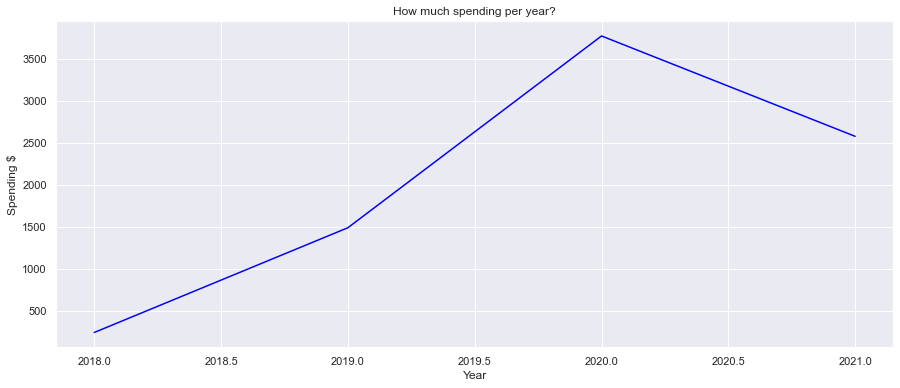

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
yoy_cost = order_data.groupby(["Year"], as_index=False).sum()
sns.lineplot(x=yoy_cost["Year"], y=yoy_cost["Cost $"], color="blue")
plt.title("How much spending per year?")
plt.ylabel("Spending $")

Text(0, 0.5, 'Count of Orders')

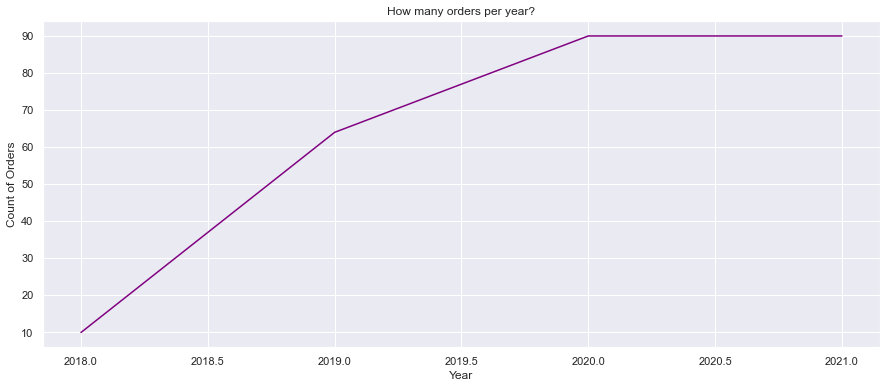

In [29]:
fig, ax = plt.subplots(figsize=(15,6))
yoy_order_count = order_data.groupby(["Year"], as_index=False).count()
sns.lineplot(x=yoy_order_count["Year"], y=yoy_order_count["Cost $"], color="Purple")
plt.title("How many orders per year?")
plt.ylabel("Count of Orders")

Text(0.5, 1.0, 'How much overall spending per month?')

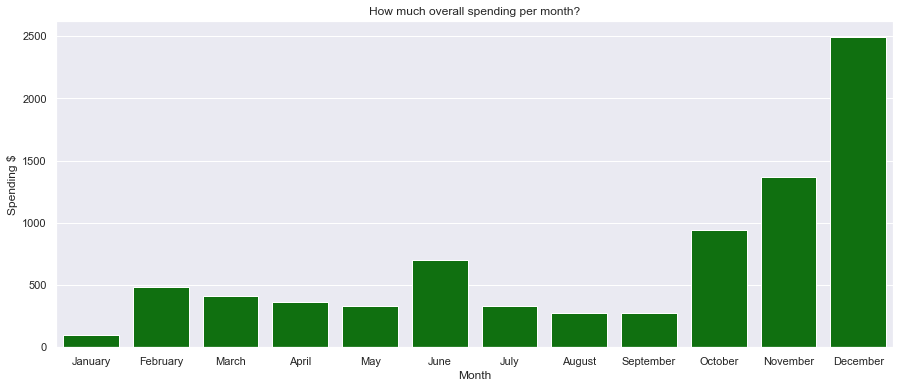

In [30]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

fig, ax = plt.subplots(figsize=(15,6))
monthly_cost = order_data.groupby(["Month"], as_index=False).sum()
sns.barplot(x=monthly_cost["Month"], y=monthly_cost["Cost $"], order=months, color="Green")
plt.ylabel("Spending $")
plt.title("How much overall spending per month?")

Text(0.5, 1.0, 'Average spending per month?')

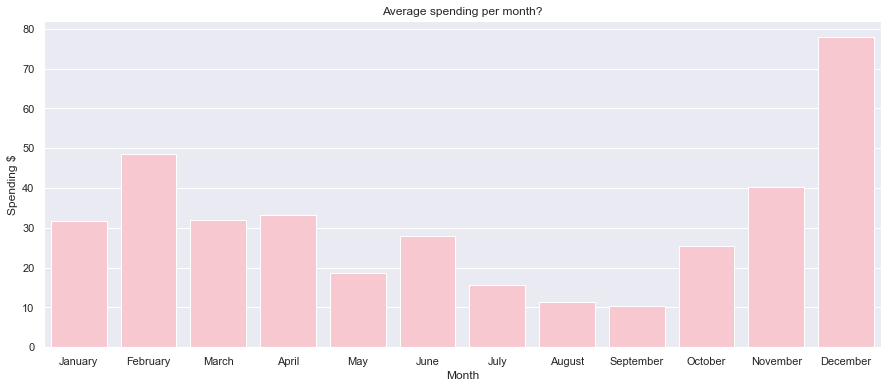

In [31]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

fig, ax = plt.subplots(figsize=(15,6))
monthly_cost = order_data.groupby(["Month"], as_index=False).mean()
sns.barplot(x=monthly_cost["Month"], y=monthly_cost["Cost $"], order=months, color="Pink")
plt.ylabel("Spending $")
plt.title("Average spending per month?")

Text(0.5, 1.0, 'Which day of the week has the highest spend?')

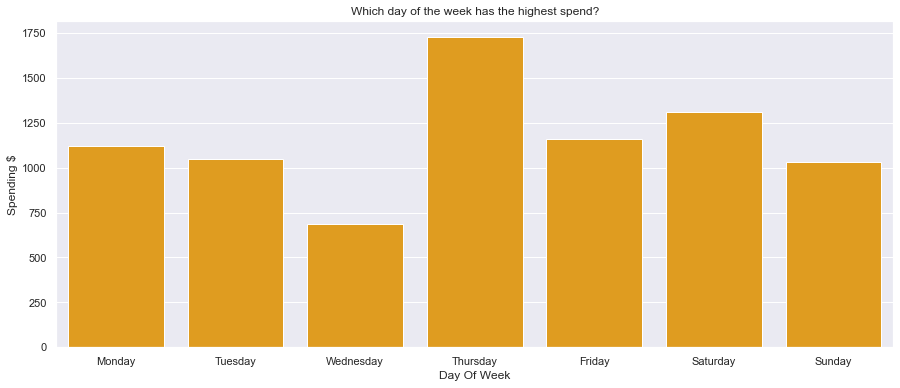

In [32]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, ax = plt.subplots(figsize=(15,6))
day_of_week_cost = order_data.groupby(["Day Of Week"], as_index=False).sum()
sns.barplot(x=day_of_week_cost["Day Of Week"], y=day_of_week_cost["Cost $"], order=days_of_week, color="Orange")
plt.ylabel("Spending $")
plt.title("Which day of the week has the highest spend?")

Text(0.5, 1.0, 'Spending Time Series')

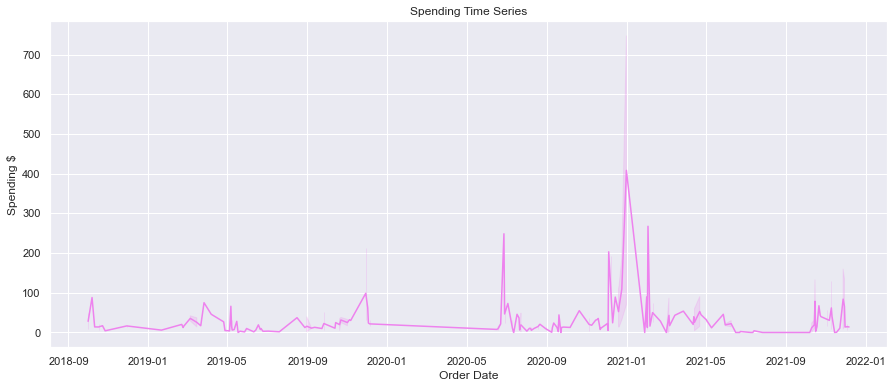

In [33]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=order_data['Order Date'], y=order_data["Cost $"], color="Violet")
plt.ylabel("Spending $")
plt.title("Spending Time Series")